# POC OCR для Паспорта РФ

https://distill.pub/2017/ctc/

https://learnopencv.com/fine-tuning-trocr-training-trocr-to-recognize-curved-text/


## Требуемые библиотеки

In [ ]:
!pip install -q transformers
!pip install -q easyocr
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q evaluate
!pip install -q -U accelerate
!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are install

In [ ]:
import os
import torch
import evaluate

import numpy as np
import pandas as pd

import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# CV
import cv2
import easyocr

from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

## Данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir_input = '/content/drive/My Drive/Data/PasportOcr/examples'
data_dir_output = '/content/drive/My Drive/Data/PasportOcr/my_out_model'
data_dir_labels = '/content/drive/My Drive/Data/PasportOcr'  # labels.xlsx

# Датасет содержит соответствие ссылки на картинку тексту на ней
labels = pd.read_excel(f"{data_dir_labels}/labels.xlsx")
labels["LINKS"] = labels["ID"].apply(lambda x: f"{data_dir_input}/{x}.png")
labels = labels.query("TARGET.notnull()")
df = labels[["LINKS", "TARGET"]]
df

Mounted at /content/drive


,LINKS,TARGET
0,/content/drive/My Drive/Data/PasportOcr/exampl...,Р О С С И Й С К А Я
1,/content/drive/My Drive/Data/PasportOcr/exampl...,Ф Е Д Е Р А
2,/content/drive/My Drive/Data/PasportOcr/exampl...,Ц И Я
3,/content/drive/My Drive/Data/PasportOcr/exampl...,ОТДЕЛЕНИЕМ
4,/content/drive/My Drive/Data/PasportOcr/exampl...,№
...,...,...
1028,/content/drive/My Drive/Data/PasportOcr/exampl...,2
1029,/content/drive/My Drive/Data/PasportOcr/exampl...,АНИКОНОВА
1030,/content/drive/My Drive/Data/PasportOcr/exampl...,ЕКАТЕРИНА
1031,/content/drive/My Drive/Data/PasportOcr/exampl...,01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1033 entries, 0 to 1032
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   LINKS   1033 non-null   object
 1   TARGET  1033 non-null   object
dtypes: object(2)
memory usage: 24.2+ KB


Всего примеров документа: 1033 , 10 первых:


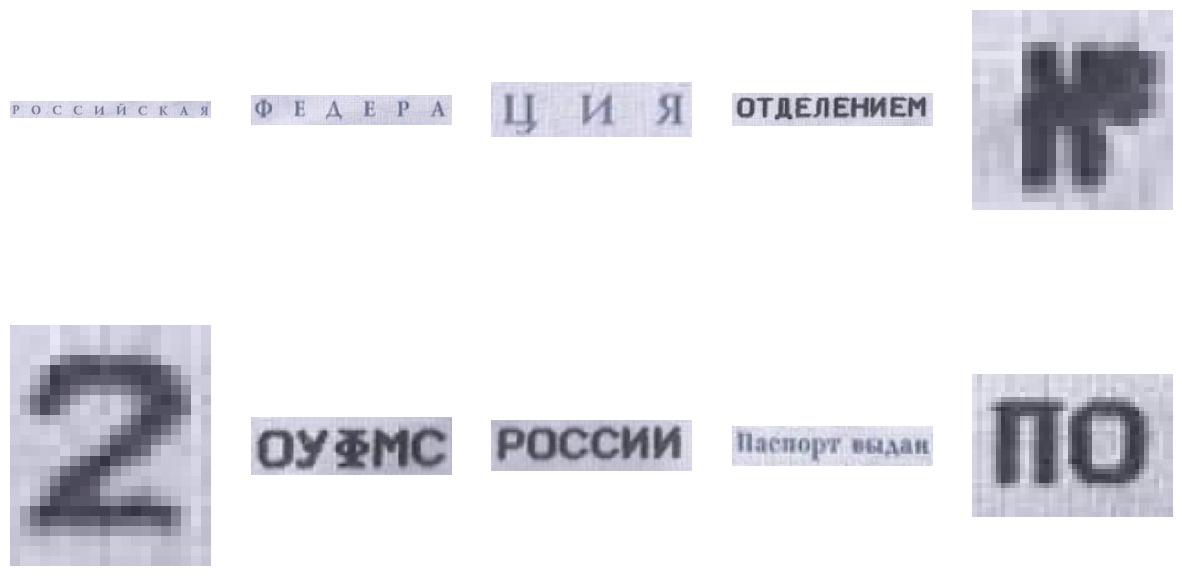

In [ ]:
# Примеры атрибутов изображения

print("Всего примеров документа:", len(df["LINKS"]), ", 10 первых:")

# Фигура визуализации изображений
fig = plt.figure(figsize=(15,8))
x = 1

# Чтение изображений для фигуры в цикле
for i in df["LINKS"][0:10]:

    img = cv2.imread(i)
    fig.add_subplot(2,5,x)
    plt.imshow(img)
    plt.axis('off')
    x += 1

plt.show()

## Общие функции

In [ ]:
# Базовые функции преобразования
def image_resizing(img):
    return cv2.resize(img, (850, 1200), interpolation = cv2.INTER_AREA)


def show_2_images(img_1, img_2):
    # Фигура визуализации изображений
    fig = plt.figure(figsize=(15,8))
    fig.add_subplot(1,2,1)
    plt.imshow(image_)
    fig.add_subplot(1,2,2)
    plt.imshow(text_detected)
    plt.show()

In [ ]:
# Детектирование боксов текста на изображении
def get_bboxes(image_resized):
    """Принимает на вход изображение и возвращает объект EasyOcr с координатами
    текстовых блоков.
    Ссылка на доку: https://jaided.ai/easyocr/documentation/
    """
    bboxes = easyocr.Reader(["ru"], gpu=True).detect(
        image_resized,
        min_size = 50,            # 10   Filter text box smaller than minimum value in pixel
        text_threshold = 0.7,     # 0.7  Text confidence threshold
        low_text = 0.3,           # 0.4  Text low-bound score
        link_threshold = 0.4,     # 0.4  Link confidence threshold
        canvas_size = 2560,       # 2560 Maximum image size. Image bigger than this value will be resized down
        mag_ratio = 1,            # 1    Image magnification ratio
        slope_ths = 0.1,          # 0.1  Maximum slope (delta y/delta x) to considered merging. Low value means tiled boxes will not be merged
        ycenter_ths = 0.5,        # 0.5  Maximum shift in y direction. Boxes with different level should not be merged
        height_ths = 0.5,         # 0.5  Maximum different in box height. Boxes with very different text size should not be merged
        width_ths = 1.1,          # 0.5  Maximum horizontal distance to merge boxes
        add_margin = 0.1,         # 0.1  Extend bounding boxes in all direction by certain value. This is important for language with complex script
        optimal_num_chars = None  # If specified (int), bounding boxes with estimated number of characters near this value are returned first
    )

    return bboxes

In [ ]:
# Настройки воспроизводимости
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 16
    EPOCHS:        int = 120
    LEARNING_RATE: float = 0.00005


@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'scut_data'


@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'


seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Аугментация
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.5, hue=0.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

## Fine Tunung

In [ ]:
# Параметры модели
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)

# Всего параметров и тренируемых параметров
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} всего параметров.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} тренируемых параметров.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [ ]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)

# Установите специальные маркеры, используемые для создания decoder_input_ids
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

# Установите правильный размер словаря
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id


model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [ ]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)


cer_metric = evaluate.load('cer')  # Character Error Rate


def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions


    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)


    cer = cer_metric.compute(predictions=pred_str, references=label_str)


    return {"cer": cer}


training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir=data_dir_output,
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [ ]:
class CustomOCRDataset(Dataset):
    def __init__(self, df, processor, max_target_length=128):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Имена картинок на диске
        file_name = self.df["LINKS"][idx]
        print(file_name)
        # Столбец с метками
        text = str(self.df["TARGET"][idx])
        # Читаем и преобразуем картинки
        image = Image.open(file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Пропустите текст через токенизатор и получите метки,
        # т.е. токенизированные метки.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # Граница -100
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding


train_dataset = CustomOCRDataset(
    df=df.head(1_000),
    processor=processor
)
valid_dataset = CustomOCRDataset(
    df=df.tail(39),
    processor=processor
)

In [ ]:
# Инициализируем обучение
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)


res = trainer.train()
# trainer.save_model('/content/drive/My Drive/Data/PasportOcr/output/model_1')
# print(trainer.state.best_model_checkpoint)

## Инференс

In [ ]:
model_dir = '/content/drive/My Drive/Data/PasportOcr/output/model_1'
test_path = '/content/drive/My Drive/Data/PasportOcr/test_examples'

In [ ]:
trained_model = VisionEncoderDecoderModel.from_pretrained(model_dir)
trained_model.cuda()
total_params = sum(p.numel() for p in trained_model.parameters())
print(f"{total_params:,} всего параметров.")

61,596,672 всего параметров.


In [ ]:
def text_recognition(image):

    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = trained_model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_text

Р О С С И  С К А Я
Ф Е Д Е F А Ц И Я
ОТДЕЛИЕМ КЛ ОУФМС РОСИ
Паспорт выдан
ПО ЖКЕСКО ОБЛАСТИ
В ЦАС ГОРСКА
Дата выдачи
78.04. 2007 Код подпись
Личя под
6292-0
Фамилия
Дамилия
Фамилия
ВЕДЕНЕВ
ВЛАДИМИР
Фась
ОЛЕГОВИЧ
Отчество
МУЖ.
09.07.1984
рождения
2
КУФСК
рождения
рождения
6292-0
Рол
рождения
УФА
Пась
Дата


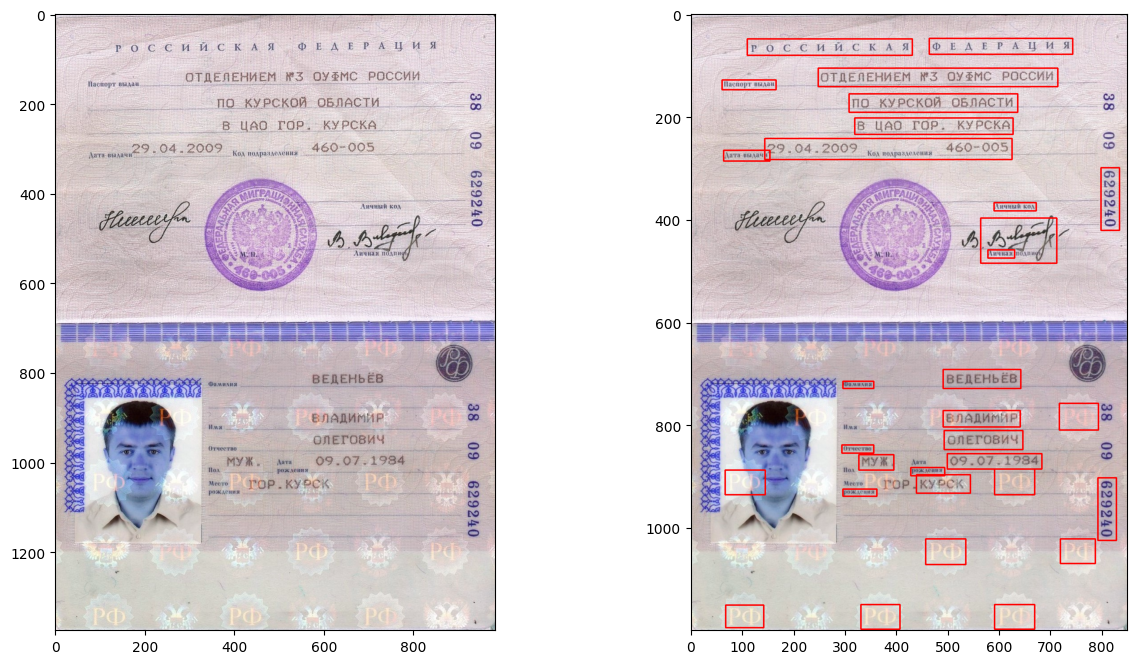

CPU times: user 9.58 s, sys: 732 ms, total: 10.3 s
Wall time: 14.5 s


In [28]:
%%time
image_ = cv2.imread(f"{test_path}/Копия 76.jpg")
image_resized = image_resizing(image_)

bboxx_h = get_bboxes(image_resized)

for h in bboxx_h[0][0]:
    croped_img = image_resized[h[2]:h[3], h[0]:h[1],]

    text_extracted = text_recognition(croped_img)
    print(text_extracted)


    text_detected = cv2.rectangle(
        image_resized, (h[0], h[2]), (h[1], h[3]),(255, 0, 0), 2
    )

# Фигура визуализации изображений
show_2_images(image_, text_detected)